# 3 Image Classication
Consider an automobile restoration company which receives thousands of vehi-
cles per day. The company hires you to build a system which can automatically
identify the manufacturer of the automobile so that it can be sent to the partic-
ular repair center. You recall the Introduction to Computer Vision course that
you took during Fall of 2018 and decide to build a logo classication system
using Histogram of Gradient (HoG) features.
The company provides you some images of dierent manufacturers' logos, as
your training images that are taken in an ideal setting (i.e. no additional back-
ground or perspective distortion) and you are asked to test your built system
on real-world images (i.e. with background and perspective distortion).
3.1 Coding Questions
For this task, you are given a set of training images (check "dataset" folder):
five logos of "Ford" and fiveve logos of "Volkswagen" (see Figure 2). You are also
given two real-world test images, one for each manufacturer. Use class label
1 for "Ford" and -1 for "Volkswagen". Build a classification system using HoG
features as follows:

In [86]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import sklearn.neighbors as sk

# Training
1. Resize the training images to 128 x 128. (0.5 points)

In [87]:
''' Function to search for file in directory'''
def getFiles(path):
    """
    Function: findFile
    Parameters: name - Name of file to search for
    return: list of found files
    """
    # Array in which results are returned
    result = []
    for root, dirs, files in os.walk(path):
        result.extend(files)
    return result
        

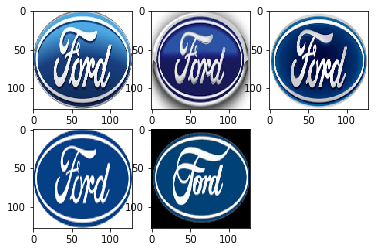

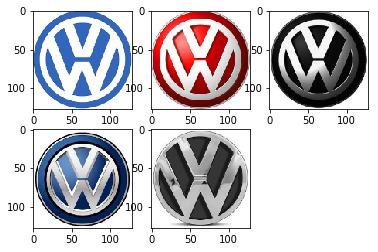

In [88]:
# Get images from working directory.

res = []
wd = os.getcwd()
direct = wd + "./dataset/"
files = getFiles(wd)
ford = []
volks = []
for entry in files:
    if "ford_train" in entry:
        ford.append(entry)
    elif "volks_train" in entry:
        volks.append(entry)

fordImg = []
volksImg = []

# Load arrays with images
for images in ford:
    image = cv2.imread(images)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fordImg.append(image)

for images in volks:
    image = cv2.imread(images)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    volksImg.append(image)

# Resize images
fordImgResized = []
volksImgResized = []

for img in fordImg:
    resized = cv2.resize(img,(128,128))
    fordImgResized.append(resized)
    
for img in volksImg:
    resized = cv2.resize(img, (128,128))
    volksImgResized.append(resized)
plt.title("Ford resized Images")
for i in range(len(fordImgResized)):
    plt.subplot(2,3,i+1)
    plt.imshow(fordImgResized[i])
    
plt.show()

for i in range((len(volksImgResized))):
    plt.subplot(2,3,i+1)
    plt.imshow(volksImgResized[i])
    
plt.show()   

2. Compute HoG features of size (32,32,8). Apply blocknorm in 4 x 4
cell neighborhood. (Deduce values of other required variables.) (11
points)
(Suggestion: Make a function which takes list of images as arguments
and delivers list of HoG features as output. The same function can
be used during testing.)

In [89]:
# Compute HoG Features

# This function is used to compute the HoG features from a list of images.
# Return results in empty array called emptyList
def computeHog(listOfImages, grayImages, hogImages):
    
    cell_size = (4, 4)  # h x w in pixels
    block_size = (4, 4)  # h x w in cells
    nbins = 8  # number of orientation bins


    
    for img in listOfImages:
        # convert image to greyscale
        img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        imgGray = img.copy()
        grayImages.append(imgGray)
        # create HoG Object
        # winSize is the size of the image cropped to an multiple of the cell size
        hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                          img.shape[0] // cell_size[0] * cell_size[0]),
                                _blockSize=(block_size[1] * cell_size[1],
                                            block_size[0] * cell_size[0]),
                                _blockStride=(cell_size[1], cell_size[0]),
                                _cellSize=(cell_size[1], cell_size[0]),
                                _nbins=nbins)

        n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])
        # Compute HoG features
        hog_feats = hog.compute(img)\
                       .reshape(n_cells[1] - block_size[1] + 1,
                                n_cells[0] - block_size[0] + 1,
                                block_size[0], block_size[1], nbins) \
                       .transpose((1, 0, 2, 3, 4))  # index blocks by rows first

        # hog_feats now contains the gradient amplitudes for each direction,for each cell of its group for each group.
        # Indexing is by rows then columns.

        # computation for BlockNorm
        gradients = np.full((n_cells[0], n_cells[1], nbins), 0, dtype=float)
        cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

        for off_y in range(block_size[0]):
            for off_x in range(block_size[1]):
                gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                          off_x:n_cells[1] - block_size[1] + off_x + 1] += \
                    hog_feats[:, :, off_y, off_x, :]
                cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                           off_x:n_cells[1] - block_size[1] + off_x + 1] += 1

        # Average gradients
        gradients /= cell_count
        
        hogImages.append(gradients)
    

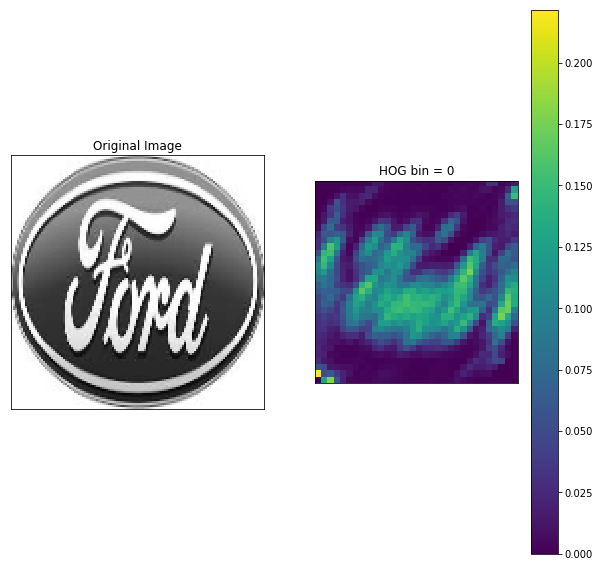

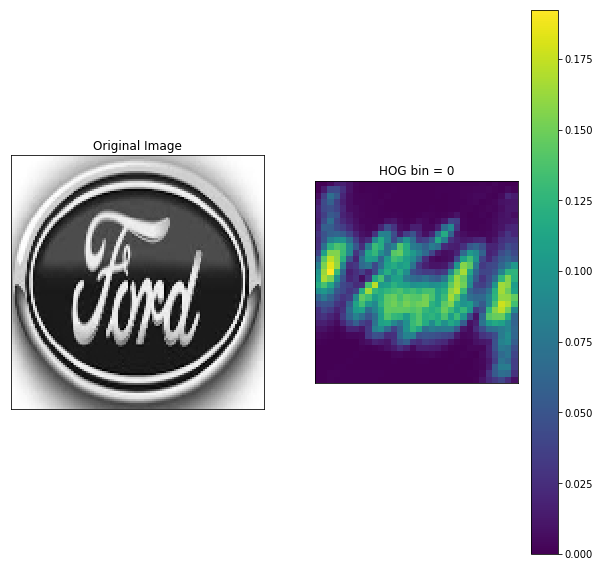

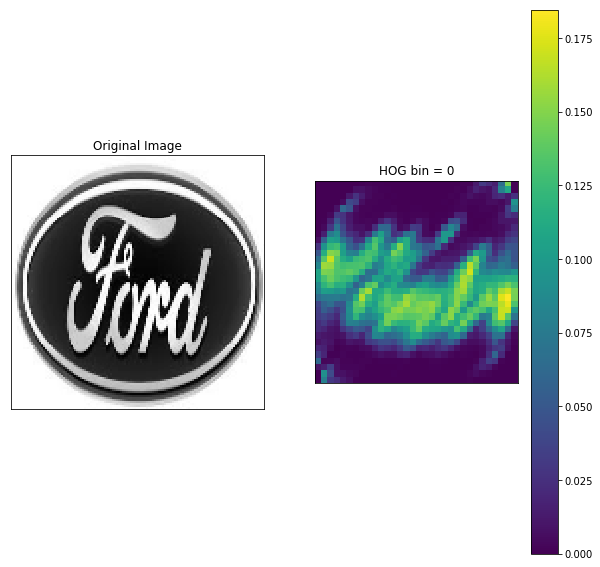

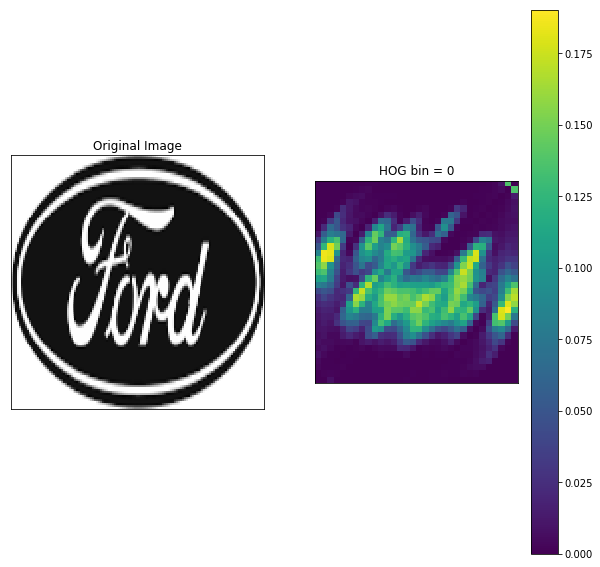

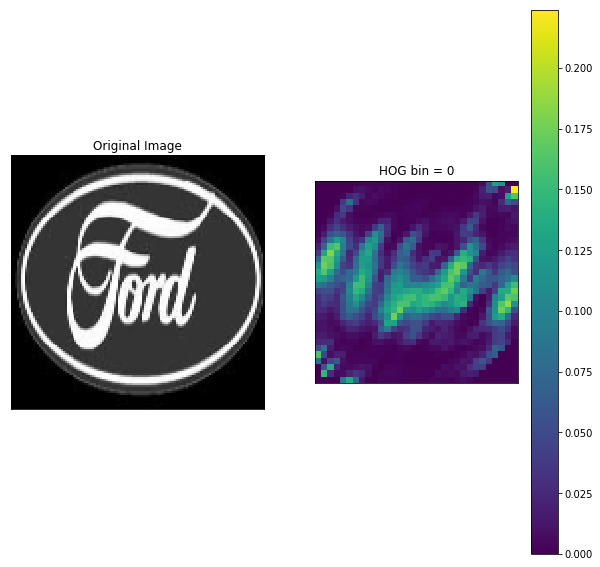

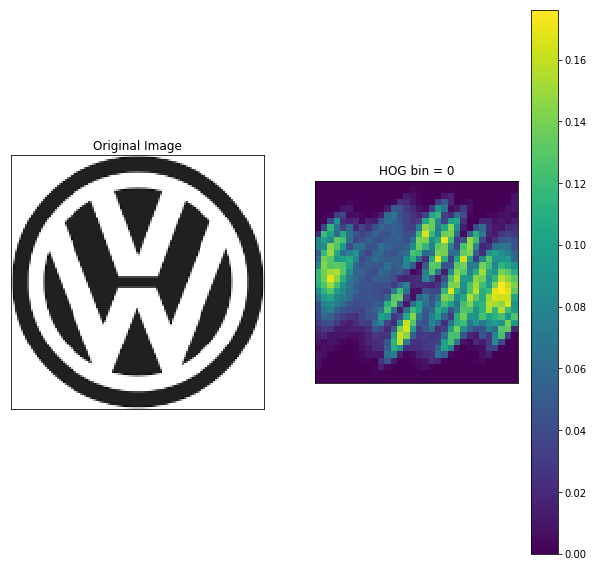

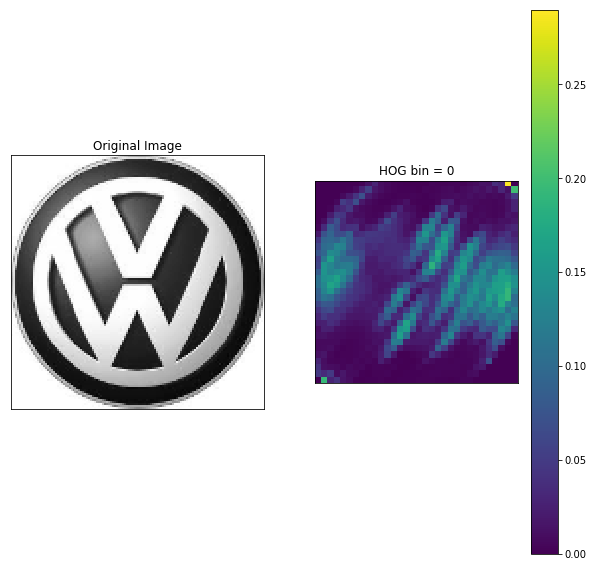

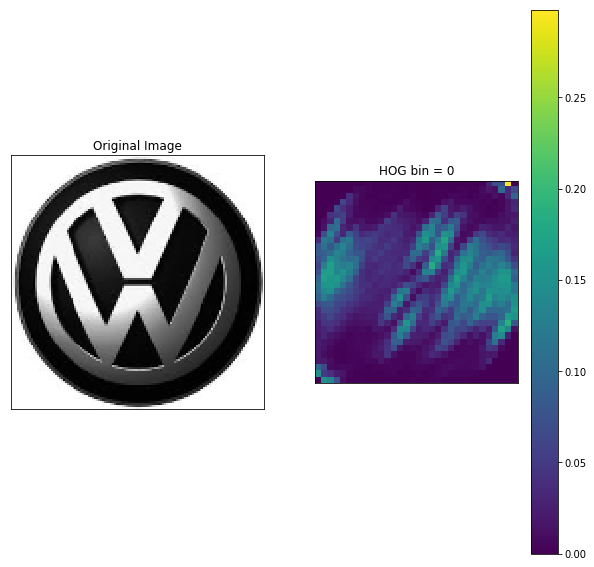

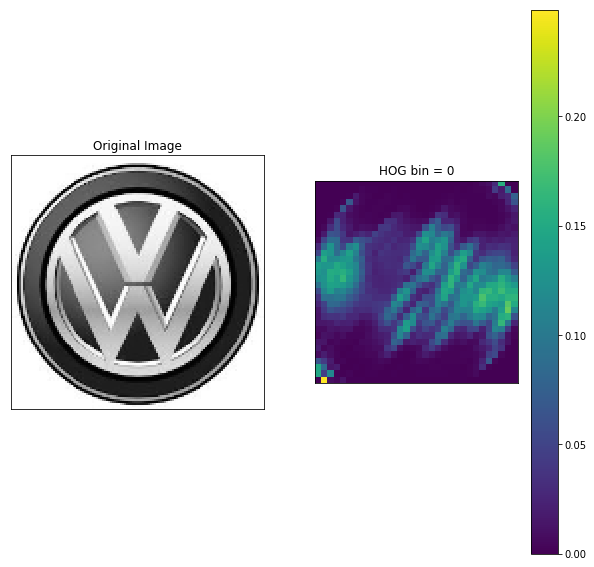

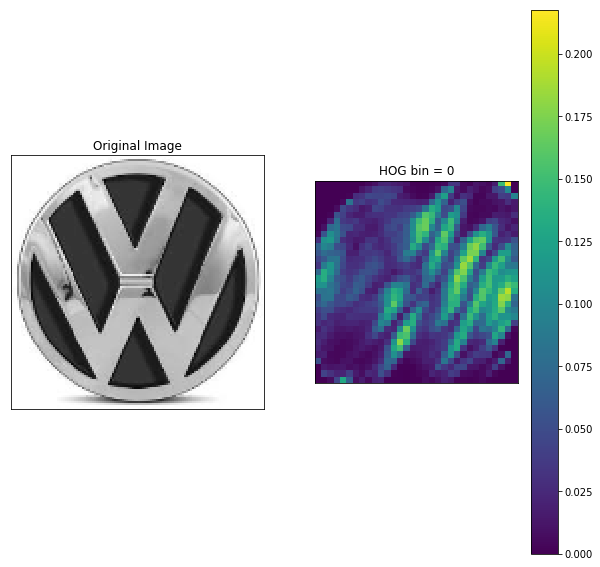

In [90]:
fordGray = []
fordHog = []

volksGray = []
volksHog = []

computeHog(fordImgResized,fordGray, fordHog)
computeHog(volksImgResized, volksGray, volksHog)

for i in range(len(fordImgResized)):
    plt.figure(figsize = (10,10))
    plt.subplot(121)
    plt.imshow(fordGray[i], cmap='gray')
    plt.title("Original Image"), plt.xticks([]), plt.yticks([])

    bin = 0  # angle is 360 / nbins * direction
    plt.subplot(122)
    plt.pcolor(fordHog[i][:, :, bin])
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("HOG bin = 0"), plt.xticks([]), plt.yticks([])
    plt.colorbar()
    plt.show()
    

for i in range(len(volksImgResized)):
    plt.figure(figsize = (10,10))
    plt.subplot(121)
    plt.imshow(volksGray[i], cmap='gray')
    plt.title("Original Image"), plt.xticks([]), plt.yticks([])

    bin = 0  # angle is 360 / nbins * direction
    plt.subplot(122)
    plt.pcolor(volksHog[i][:, :, bin])
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("HOG bin = 0"), plt.xticks([]), plt.yticks([])
    plt.colorbar()
    plt.show()   

Fit a nearest neighbor classifier with three neighbors. Use KNeighborsClassifier
from sklearn library. (2 points)

In [91]:
KNeighbors = sk.KNeighborsClassifier(n_neighbors = 3)

hogList = fordHog + volksHog
classif = [1,1,1,1,1,-1,-1,-1,-1,-1]

hogListArr = np.asarray(hogList)
classifArr = np.asarray(classif)
hogListArr = hogListArr.reshape(10,-1)

KNeighbors.fit(hogListArr,classifArr)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

Testing
1. Resize test images to 128 x 128. (0.5 points)

In [92]:
testFord = cv2.imread("./dataset/ford_test.jpeg")
fordOG = testFord.copy()
testVolks = cv2.imread("./dataset/volks_test.jpeg")
volksOG = testVolks.copy()

testFord = cv2.resize(testFord,(128,128))
testVolks = cv2.resize(testVolks,(128,128))

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(fordOG)
plt.title("Original Ford")
plt.subplot(2,2,2)
plt.imshow(testFord)
plt.title("Resized Ford")
plt.subplot(2,2,3)
plt.imshow(volksOG)
plt.title("Original Volks")
plt.subplot(2,2,4)
plt.imshow(testVolks)
plt.title("Resized Volks")

plt.show()

AttributeError: 'NoneType' object has no attribute 'copy'

2. Compute HoG features similar to what was done during training. (2
points)

In [ ]:
testImgArr = [testFord, testVolks]
testHog = []
testGray = []

computeHog(testImgArr,testGray, testHog)



3. Display the features for both test images. (3 points)

In [ ]:
for i in range(len(testImgArr)):
    plt.figure(figsize = (10,10))
    plt.subplot(121)
    plt.imshow(testGray[i], cmap='gray')
    plt.title("Original Image"), plt.xticks([]), plt.yticks([])

    bin = 0  # angle is 360 / nbins * direction
    plt.subplot(122)
    plt.pcolor(testHog[i][:, :, bin])
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("HOG bin = 0"), plt.xticks([]), plt.yticks([])
    plt.colorbar()
    plt.show()  

4. Classify the test images using the classier built above. (1 points)

In [ ]:
testHog = np.asarray(testHog)
testHog = testHog.reshape(testHog.shape[0], -1)
KNeighbors.predict(testHog)


#volksClass = KNeighbors.predict(testHog[1])

#print("Ford predicted class", fordClass)
#print("Volkswagen predicted class", volksClass)